# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Prof.: Dra. Grettel Barceló

## **Actividad Semana 2**

### **Exploración Inicial de Datos**

##### Nombres y matrículas de los integrantes del equipo:
*   Omar Juárez Téllez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827

---


#### **Objetivo de la Actividad:**

Revisión de estructura del dataset, identificación de
problemas de calidad de datos, y reporte preliminar de dataset.


---

## **1. Importación de Librerías**

In [2]:
!pip install -q sentence-transformers transformers accelerate unidecode
!pip install -q regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.4 MB/s eta 0:00:00


In [59]:
import io
import os
import gc
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthBegin
import re
from unidecode import unidecode
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 200)

# Configuración visual
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## **2. Carga de Datos**

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.1 Preparación del Entorno y Lectura del Dataset**

In [61]:
# Ruta base donde están los archivos
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/DATOS/v3/Predicción de hospitalizaciones"

In [62]:
# Función auxiliar para probar con distintos encodings y separadores
def load_txt(fname, sep="\t", encoding="utf-8"):
    try:
        return pd.read_csv(fname, sep=sep, encoding=encoding)
    except UnicodeDecodeError:
        # si falla UTF-8, intenta con latin1
        return pd.read_csv(fname, sep=sep, encoding="latin1")

# 1. Población
df_poblacion = load_txt(f"{base_path}/01-Poblacion_v02.txt")

# 2. Biomarcadores
df_biomarcadores = load_txt(f"{base_path}/02-Biomarcadores.txt")

# 3. Notas médicas
df_notas = load_txt(f"{base_path}/03-Notas_Medicas.txt")

# 4. Hospitalizaciones
df_hosp = load_txt(f"{base_path}/04-Hospitalizaciones.txt")

# 5. Motivos de consultas
df_motivosconsultas = load_txt(f"{base_path}/05-Motivo_Consultas.txt")

# 6. Prescripciones
df_prescripciones = load_txt(f"{base_path}/06-Prescripciones.txt")

# 7. Rangos de referencia de biomarcadores (Excel)
df_rangos = pd.read_excel(f"{base_path}/Rangos de referencia_biomarcadores.xlsx")

In [69]:
# Normalización de nombres de columnas por consistencia
rename_map = {
    "PERIORICIDAD": "PERIODICIDAD",
    "Perioricidad": "PERIODICIDAD",
    "periodicidad": "PERIODICIDAD",
    "valor_minimo": "VALOR_MINIMO",
    "valor_maximo": "VALOR_MAXIMO",
}
df_rangos = df_rangos.rename(columns=rename_map)

# Conversión de tipos
df_rangos["ID_BIOMARCADOR"] = df_rangos["ID_BIOMARCADOR"].astype("Int64")
for col in ["VALOR_MINIMO", "VALOR_MAXIMO"]:
    if col in df_rangos.columns:
        df_rangos[col] = pd.to_numeric(df_rangos[col], errors="coerce")

# --- Helpers ---
# Mapa de periodicidades del catálogo → reglas pandas
FREQ_MAP = {
    "Diaria": "D",
    "Semanal": "W",
    "Quincenal": "2W",
    "Mensual": "MS",      # mes a inicio
    "Trimestral": "QS",   # trimestre a inicio
    "Semestral": "2QS",
    "Anual": "YS",
}

# Validamos la correcta carga de los dataset
for name, df in {
    "Población": df_poblacion,
    "Biomarcadores": df_biomarcadores,
    "Notas Médicas": df_notas,
    "Hospitalizaciones": df_hosp,
    "Motivos de consultas": df_motivosconsultas,
    "Prescripciones": df_prescripciones,
    "Rangos": df_rangos
}.items():
    print(f"\n=== {name} ===")
    print(df.shape)
    #print(df.head(3))


=== Población ===
(295, 7)

=== Biomarcadores ===
(50514, 5)

=== Notas Médicas ===
(8421, 9)

=== Hospitalizaciones ===
(11, 4)

=== Motivos de consultas ===
(1615, 6)

=== Prescripciones ===
(18644, 10)

=== Rangos ===
(140, 6)


**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [70]:
# --- Poblacion ---
df_poblacion["FECHA_AFILIACION"] = pd.to_datetime(df_poblacion["FECHA_AFILIACION"], format="%d/%m/%Y", errors="coerce")
df_poblacion["FECHA_EGRESO"]     = pd.to_datetime(df_poblacion["FECHA_EGRESO"], format="%d/%m/%Y", errors="coerce")
df_poblacion["FECHA_NACIMIENTO"] = pd.to_datetime(df_poblacion["FECHA_NACIMIENTO"], format="%d/%m/%Y", errors="coerce")

# --- Biomarcadores ---
df_biomarcadores["FECHA"] = pd.to_datetime(df_biomarcadores["FECHA"], format="%d/%m/%Y", errors="coerce")

# --- Notas médicas ---
df_notas["FECHA"] = pd.to_datetime(df_notas["FECHA"], format="%d/%m/%Y", errors="coerce")

# --- Hospitalizaciones ---
df_hosp["FECHA_HOSPITALIZACION"] = pd.to_datetime(df_hosp["FECHA_HOSPITALIZACION"], format="%d/%m/%Y", errors="coerce")

# --- Motivos de consultas ---
df_motivosconsultas["FECHA"] = pd.to_datetime(df_motivosconsultas["FECHA"], format="%d/%m/%Y", errors="coerce")

## **3. Construcción de Master Table**

**3.1 Generar el universo de pacientes por mes**

In [71]:
# --- 1) Parámetros del universo ---
FIN_CENSURA = pd.Timestamp("2025-09-05")   # último mes a incluir si el paciente sigue activo
ANCLA_DIA   = 5                            # día "inicio de mes" operativo

def primer_dia5_en_o_despues(fecha: pd.Timestamp) -> pd.Timestamp:
    """Devuelve el primer día 5 en o después de 'fecha'."""
    if pd.isna(fecha):
        return pd.NaT
    # día 5 del mismo mes
    d5_mes = pd.Timestamp(fecha.year, fecha.month, ANCLA_DIA)
    # si la afiliación es antes o el mismo 5 -> toma ese; si es después -> 5 del mes siguiente
    return d5_mes if fecha <= d5_mes else (fecha + MonthBegin(1)) + pd.Timedelta(days=ANCLA_DIA-1)

In [72]:
# --- 2) Fechas de inicio y fin por paciente ---
pop = df_poblacion[["ID_EHT","FECHA_AFILIACION","FECHA_EGRESO","GENERO","FECHA_NACIMIENTO","UBICACION"]].copy()
pop["START_MES_5"] = pop["FECHA_AFILIACION"].apply(primer_dia5_en_o_despues)
pop["END_MES_5"]   = pop["FECHA_EGRESO"].fillna(FIN_CENSURA)

# Filtra registros sin ventana válida (p.ej. afiliación > egreso accidentalmente)
pop = pop[pop["START_MES_5"] <= pop["END_MES_5"]].copy()

In [73]:
# --- 3) Calendario de días 5 (global) ---
start_global = pop["START_MES_5"].min()
fechas_5 = (pd.date_range(start=start_global.normalize().replace(day=1),
                          end=FIN_CENSURA.normalize().replace(day=1),
                          freq="MS") + pd.Timedelta(days=ANCLA_DIA-1))
cal = pd.DataFrame({"FECHA_MES_5": fechas_5})
cal["CODMES"] = cal["FECHA_MES_5"].dt.to_period("M").astype(str)  # 'YYYY-MM'

In [74]:
# --- 4) Cross-join universo paciente–mes y filtro por ventana individual ---
pop["key"] = 1
cal["key"] = 1
universo = (pop.merge(cal, on="key", how="outer")
              .drop(columns="key"))

# Mantener solo meses donde el paciente está “afiliado al inicio de mes (día 5)”
universo = universo[(universo["FECHA_MES_5"] >= universo["START_MES_5"]) &
                    (universo["FECHA_MES_5"] <= universo["END_MES_5"])].copy()

# Orden y columnas útiles
universo = (universo
            .sort_values(["ID_EHT","FECHA_MES_5"])
            .reset_index(drop=True))

# Columnas de control
# Dias con Previta
universo["DIAS_EN_PROGRAMA"] = (universo["FECHA_MES_5"] - universo["FECHA_AFILIACION"]).dt.days

# Edad del paciente en cada mes
universo["EDAD"] = ((universo["FECHA_MES_5"] - universo["FECHA_NACIMIENTO"]).dt.days // 365)

In [75]:
universo[universo['ID_EHT'] == 'aacevedo2146542'] # mbuenrostro2379432 vpoot2336437

,ID_EHT,FECHA_AFILIACION,FECHA_EGRESO,GENERO,FECHA_NACIMIENTO,UBICACION,START_MES_5,END_MES_5,FECHA_MES_5,CODMES,DIAS_EN_PROGRAMA,EDAD
36,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-03-05,2023-03,23,66
37,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-04-05,2023-04,54,66
38,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-05-05,2023-05,84,66
39,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-06-05,2023-06,115,66
40,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-07-05,2023-07,145,66
41,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-08-05,2023-08,176,66
42,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-09-05,2023-09,207,66
43,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-10-05,2023-10,237,66
44,aacevedo2146542,2023-02-10,2023-11-28,M,1956-10-25,CDMX,2023-03-05,2023-11-28,2023-11-05,2023-11,268,67


**3.2 Construir Variables de Biomarcadores**

In [76]:
# --- 1) Función de normalización para que el mapeo sea robusto a tildes, mayúsculas/minúsculas y espacios ---
def normalize_name(s: str) -> str:
    """Normaliza: trim, mayúsculas, colapsa espacios, quita tildes."""
    if pd.isna(s):
        return s
    s = str(s).strip().upper()
    s = " ".join(s.split())
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
    return s

In [77]:
# --- 2) Mapeo de biomarcador ---
#        Creamos la lista de Previta acerca de biomarcadores
freq_by_biom = {
    # ANUAL
    normalize_name("Índice Aterogénico"): "ANUAL",
    normalize_name("Riesgo Cardiovascular"): "ANUAL",

    # SEMESTRAL
    normalize_name("% grasa"): "SEMESTRAL",
    normalize_name("Microalbuminuria"): "SEMESTRAL",
    normalize_name("Hemoglobina"): "SEMESTRAL",
    normalize_name("Eritrocitos"): "SEMESTRAL",
    normalize_name("Leucocitos totales"): "SEMESTRAL",
    normalize_name("Neutrófilos"): "SEMESTRAL",
    normalize_name("Monocitos"): "SEMESTRAL",
    normalize_name("Eoscinofilos"): "SEMESTRAL",
    normalize_name("Basófilos"): "SEMESTRAL",
    normalize_name("Linfocitos"): "SEMESTRAL",
    normalize_name("Hematocritos"): "SEMESTRAL",
    normalize_name("Hemoglobina corpuscular media"): "SEMESTRAL",
    normalize_name("Concentración de hemoglobina corpuscular media"): "SEMESTRAL",
    normalize_name("Volumen corpuscular medio"): "SEMESTRAL",
    normalize_name("Velocidad de sedimentación globular > 50"): "SEMESTRAL",
    normalize_name("Velocidad de sedimentación globular < 50"): "SEMESTRAL",
    normalize_name("Glucosa en orina"): "SEMESTRAL",
    normalize_name("Urea"): "SEMESTRAL",
    normalize_name("Acido úrico"): "SEMESTRAL",
    normalize_name("Proteína total"): "SEMESTRAL",
    normalize_name("Albumina"): "SEMESTRAL",
    normalize_name("TGO"): "SEMESTRAL",
    normalize_name("TGP"): "SEMESTRAL",
    normalize_name("pH"): "SEMESTRAL",
    normalize_name("Densidad"): "SEMESTRAL",
    normalize_name("Hormona estimulante de tiroides (TSH)"): "SEMESTRAL",
    normalize_name("Triyodotironina (T3)"): "SEMESTRAL",
    normalize_name("Tiroxina (T4)"): "SEMESTRAL",
    normalize_name("T4 libre"): "SEMESTRAL",
    normalize_name("Hemoglobina Glucosilada -"): "SEMESTRAL",
    normalize_name("Nitrógeno ureico (BUN)"): "SEMESTRAL",
    normalize_name("Albumina en suero"): "SEMESTRAL",
    normalize_name("Proteínas totales séricas"): "SEMESTRAL",
    normalize_name("Globulina"): "SEMESTRAL",
    normalize_name("Deshidrogenasa láctica"): "SEMESTRAL",
    normalize_name("Bilirrubina directa"): "SEMESTRAL",
    normalize_name("Bilirrubina indirecta"): "SEMESTRAL",
    normalize_name("Bilirrubina total"): "SEMESTRAL",
    normalize_name("Transaminasa glutámico oxalacetica (TGO)"): "SEMESTRAL",
    normalize_name("Transaminasa G Pirúvica (TGP)"): "SEMESTRAL",
    normalize_name("Gamaglutamiltranspeptidasa (GGT)"): "SEMESTRAL",
    normalize_name("Proteína C reactiva"): "SEMESTRAL",
    normalize_name("Sodio"): "SEMESTRAL",
    normalize_name("Potasio"): "SEMESTRAL",
    normalize_name("TSH"): "SEMESTRAL",
    normalize_name("Testosterona"): "SEMESTRAL",
    normalize_name("Progesterona"): "SEMESTRAL",
    normalize_name("Factor reumatoide -"): "SEMESTRAL",
    normalize_name("CA 15-3"): "SEMESTRAL",
    normalize_name("CA 125"): "SEMESTRAL",
    normalize_name("Hormona folículo estimulante"): "SEMESTRAL",
    normalize_name("Hormona leutinizante"): "SEMESTRAL",
    normalize_name("FEV 1/FVC"): "SEMESTRAL",
    normalize_name("Porcentaje muscular"): "SEMESTRAL",
    normalize_name("Sangre oculta en heces por inmunohistoquimica /FIT"): "SEMESTRAL",
    normalize_name("Oximetría capilar"): "SEMESTRAL",
    normalize_name("Circunferencia de cintura"): "SEMESTRAL",
    normalize_name("Antígeno prostático especifico"): "SEMESTRAL",
    normalize_name("Ferritina"): "SEMESTRAL",
    normalize_name("Troponina I ultrasensible"): "SEMESTRAL",
    normalize_name("Amilasa"): "SEMESTRAL",
    normalize_name("PCR Ultrasensible"): "SEMESTRAL",
    normalize_name("TUPTAKE captación"): "SEMESTRAL",
    normalize_name("Yodo Proteico"): "SEMESTRAL",
    normalize_name("Indice de toroxina libre (ITL, FTI, T7)"): "SEMESTRAL",
    normalize_name("Fosfata Alcalina"): "SEMESTRAL",
    normalize_name("Insulina"): "SEMESTRAL",
    normalize_name("Indice de Resistencia a la insulina"): "SEMESTRAL",
    normalize_name("Relacion AGG"): "SEMESTRAL",
    normalize_name("Calcio"): "SEMESTRAL",
    normalize_name("Fosforo"): "SEMESTRAL",
    normalize_name("Hierro"): "SEMESTRAL",
    normalize_name("Volumen Globular Medio"): "SEMESTRAL",
    normalize_name("ADE"): "SEMESTRAL",
    normalize_name("Volumen Plaquetario Medio"): "SEMESTRAL",
    normalize_name("NeutroFilos en banda %"): "SEMESTRAL",
    normalize_name("Metamielocitos"): "SEMESTRAL",
    normalize_name("Promielocitos"): "SEMESTRAL",
    normalize_name("Blastos"): "SEMESTRAL",
    normalize_name("Neutrofilos en banda absolutos"): "SEMESTRAL",
    normalize_name("Eosinofilos Absolutos"): "SEMESTRAL",
    normalize_name("Basofilos Absolutos"): "SEMESTRAL",
    normalize_name("Monocitos Absolutos"): "SEMESTRAL",
    normalize_name("Linfocitos Absolutos"): "SEMESTRAL",
    normalize_name("Mielocitos"): "SEMESTRAL",
    normalize_name("Neutrofilos"): "SEMESTRAL",
    normalize_name("Neutrofilos Absolutos"): "SEMESTRAL",
    normalize_name("FEVI"): "SEMESTRAL",

    # CUATRIMESTRAL
    normalize_name("Colesterol total"): "CUATRIMESTRAL",
    normalize_name("Triglicéridos"): "CUATRIMESTRAL",
    normalize_name("Colesterol HDL"): "CUATRIMESTRAL",
    normalize_name("Colesterol LDL"): "CUATRIMESTRAL",
    normalize_name("Hemoglobina glucosilada (HbA1c)"): "CUATRIMESTRAL",
    normalize_name("Circunferencia abdominal"): "CUATRIMESTRAL",
    normalize_name("Colesterol VLDL"): "CUATRIMESTRAL",
    normalize_name("Creatinina sérica"): "CUATRIMESTRAL",
    normalize_name("Plaquetas"): "CUATRIMESTRAL",
    normalize_name("Creatinina"): "CUATRIMESTRAL",

    # TRIMESTRAL
    normalize_name("Glucosa en suero (Ayuno)"): "TRIMESTRAL",
    normalize_name("Glucosa en suero (Alimentos)"): "TRIMESTRAL",

    # MENSUAL
    normalize_name("Tensión arterial sistólica"): "MENSUAL",
    normalize_name("Tensión arterial diastólica"): "MENSUAL",
    normalize_name("Frecuencia cardiaca"): "MENSUAL",
    normalize_name("Frecuencia respiratoria"): "MENSUAL",
    normalize_name("Temperatura"): "MENSUAL",
    normalize_name("Peso"): "MENSUAL",
    normalize_name("Talla"): "MENSUAL",
    normalize_name("IMC"): "MENSUAL",
    normalize_name("Relación Cintura / Cadera"): "MENSUAL",
    normalize_name("Cintura"): "MENSUAL",
    normalize_name("Cadera"): "MENSUAL",
}

# Frecuencia -> días de ventana
days_by_freq = {
    "MENSUAL": 30,
    "TRIMESTRAL": 90,
    "CUATRIMESTRAL": 120,
    "SEMESTRAL": 180,
    "ANUAL": 365,
}

In [78]:
# --- 3) Asegurar tipos correctos ---
df_biomarcadores = df_biomarcadores.copy()
df_biomarcadores["FECHA"] = pd.to_datetime(df_biomarcadores["FECHA"], errors="coerce")
if df_biomarcadores["VALOR"].dtype == "O":
    df_biomarcadores["VALOR"] = pd.to_numeric(df_biomarcadores["VALOR"], errors="coerce")

In [79]:
# --- 4) Universo paciente–mes ---
universo = universo.copy()

In [80]:
# --- 5) Prepara biomarcadores + normalización de nombre ---
bm = (
    df_biomarcadores[["ID_EHT", "NOMBRE_BIOMARCADOR", "VALOR", "FECHA"]]
    .dropna(subset=["ID_EHT", "FECHA"])
    .copy()
)
bm["NOMBRE_BIOMARCADOR_NORM"] = bm["NOMBRE_BIOMARCADOR"].map(normalize_name)

In [81]:
# --- 6) Anexar frecuencia y días de ventana por biomarcador ---
bm["FRECUENCIA"] = bm["NOMBRE_BIOMARCADOR_NORM"].map(freq_by_biom)

# Fallback: si no está en el mapeo, trátalo como MENSUAL (30 días) o pon NaN si prefieres forzar DQ

bm["FRECUENCIA"] = bm["FRECUENCIA"].fillna("MENSUAL")
bm["WINDOW_DAYS"] = bm["FRECUENCIA"].map(days_by_freq).fillna(30).astype(int)

In [82]:
# --- 7) Join por paciente + ventana dinámica [FECHA_MES_5 - WINDOW_DAYS(biom), FECHA_MES_5] ---
cand = bm.merge(universo[["ID_EHT", "FECHA_MES_5"]], on="ID_EHT", how="inner")
cand["WINDOW_START"] = cand["FECHA_MES_5"] - pd.to_timedelta(cand["WINDOW_DAYS"], unit="D")

m = (cand["FECHA"] >= cand["WINDOW_START"]) & (cand["FECHA"] <= cand["FECHA_MES_5"])
cand = cand.loc[m].copy()

In [85]:
# --- 8) Agregación: promedio en la ventana por paciente–mes–biomarcador ---
agg_mean = (
    cand.groupby(["ID_EHT", "FECHA_MES_5", "NOMBRE_BIOMARCADOR_NORM"], as_index=False)["VALOR"]
    .mean()
    .rename(columns={"VALOR": "VALOR_MEAN_WIN"})
)

'''
(Opcional) si prefieres MEDIANA en lugar de promedio:
agg_mean = (cand.groupby(["ID_EHT","FECHA_MES_5","NOMBRE_BIOMARCADOR"], as_index=False)["VALOR"]
                  .median()
                  .rename(columns={"VALOR":"VALOR_MEDIAN_30D"}))
'''

'\n(Opcional) si prefieres MEDIANA en lugar de promedio:\nagg_mean = (cand.groupby(["ID_EHT","FECHA_MES_5","NOMBRE_BIOMARCADOR"], as_index=False)["VALOR"]\n                  .median()\n                  .rename(columns={"VALOR":"VALOR_MEDIAN_30D"}))\n'

In [86]:
# --- 9) Pivot a ancho ---
bm_wide = (
    agg_mean.pivot(index=["ID_EHT", "FECHA_MES_5"],
                   columns="NOMBRE_BIOMARCADOR_NORM",
                   values="VALOR_MEAN_WIN")
    .reset_index()
)

# Limpieza de nombres de columnas (similar a tu lógica)
bm_wide.columns = [
    (
        str(c).strip()
        .replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("/", "_")
        .replace("%", "pct")
    )
    for c in bm_wide.columns
]

In [87]:
# --- 10) Merge final contra el universo ---
master_pm_varwin = (
    universo.merge(bm_wide, on=["ID_EHT", "FECHA_MES_5"], how="left")
)

master_pm_30d = master_pm_varwin

In [88]:
master_pm_30d[master_pm_30d['ID_EHT'] == 'mbuenrostro2379432']

,ID_EHT,FECHA_AFILIACION,FECHA_EGRESO,GENERO,FECHA_NACIMIENTO,UBICACION,START_MES_5,END_MES_5,FECHA_MES_5,CODMES,DIAS_EN_PROGRAMA,EDAD,pct_GRASA,ACIDO_URICO,ADE,ALBUMINA,ALBUMINA_EN_SUERO,AMILASA,ANTIGENO_PROSTATICO_ESPECIFICO,BASOFILOS,BASOFILOS_ABSOLUTOS,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,BLASTOS,CA_125,CA_15-3,CADERA,CALCIO,CINTURA,CIRCUNFERENCIA_ABDOMINAL,CIRCUNFERENCIA_DE_CINTURA,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CONCENTRACION_DE_HEMOGLOBINA_CORPUSCULAR_MEDIA,CREATININA,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,EOSCINOFILOS,EOSINOFILOS_ABSOLUTOS,ERITROCITOS,FACTOR_REUMATOIDE_-,FERRITINA,FEV_1_FVC,FEVI,FOSFATA_ALCALINA,FOSFORO,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,GAMAGLUTAMILTRANSPEPTIDASA_GGT,GLOBULINA,GLUCOSA_EN_ORINA,GLUCOSA_EN_SUERO_ALIMENTOS,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_CORPUSCULAR_MEDIA,...,HORMONA_FOLICULO_ESTIMULANTE,HORMONA_LEUTINIZANTE,IMC,INDICE_ATEROGENICO,INDICE_DE_RESISTENCIA_A_LA_INSULINA,"INDICE_DE_TOROXINA_LIBRE_ITL,_FTI,_T7",INSULINA,LEUCOCITOS_TOTALES,LINFOCITOS,LINFOCITOS_ABSOLUTOS,METAMIELOCITOS,MICROALBUMINURIA,MIELOCITOS,MONOCITOS,MONOCITOS_ABSOLUTOS,NEUTROFILOS,NEUTROFILOS_ABSOLUTOS,NEUTROFILOS_EN_BANDA_pct,NEUTROFILOS_EN_BANDA_ABSOLUTOS,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PCR_ULTRASENSIBLE,PESO,PH,PLAQUETAS,PORCENTAJE_MUSCULAR,POTASIO,PROGESTERONA,PROMIELOCITOS,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,PROTEINAS_TOTALES_SERICAS,RELACION_AGG,RELACION_CINTURA___CADERA,RIESGO_CARDIOVASCULAR,SANGRE_OCULTA_EN_HECES_POR_INMUNOHISTOQUIMICA__FIT,SODIO,T4_LIBRE,TALLA,TEMPERATURA,TENSION_ARTERIAL_DIASTOLICA,TENSION_ARTERIAL_SISTOLICA,TESTOSTERONA,TGO,TGP,TIROXINA_T4,TRANSAMINASA_G_PIRUVICA_TGP,TRANSAMINASA_GLUTAMICO_OXALACETICA_TGO,TRIGLICERIDOS,TRIYODOTIRONINA_T3,TROPONINA_I_ULTRASENSIBLE,TSH,TUPTAKE_CAPTACION,UREA,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_<_50,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_>_50,VOLUMEN_CORPUSCULAR_MEDIO,VOLUMEN_GLOBULAR_MEDIO,VOLUMEN_PLAQUETARIO_MEDIO,YODO_PROTEICO
3419,mbuenrostro2379432,2025-02-18,NaT,F,1948-07-01,CDMX,2025-03-05,2025-09-05,2025-03-05,2025-03,15,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3420,mbuenrostro2379432,2025-02-18,NaT,F,1948-07-01,CDMX,2025-03-05,2025-09-05,2025-04-05,2025-04,46,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3421,mbuenrostro2379432,2025-02-18,NaT,F,1948-07-01,CDMX,2025-03-05,2025-09-05,2025-05-05,2025-05,76,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422,mbuenrostro2379432,2025-02-18,NaT,F,1948-07-01,CDMX,2025-03-05,2025-09-05,2025-06-05,2025-06,107,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

**3.3 Construir Variables Notas Médicas, Diagnósticos y Medicación**

**3.3.1 Notas Médicas (df_notas) → señales de texto (recency-weighted)**

In [89]:
# --- Parámetros ---
VENTANA_DIAS = 30
TAU = 7  # "half-life" ~ recencia: a menor TAU, más peso a lo reciente

# --- Universo paciente x mes ---
# columnas mínimas: ['ID_EHT', 'FECHA_MES_5']
univ = universo[["ID_EHT","FECHA_MES_5"]].copy()
univ["WINDOW_START"] = univ["FECHA_MES_5"] - pd.Timedelta(days=VENTANA_DIAS)

In [90]:
# --- Función auxiliar para peso por recencia ---
def add_recency_weight(df, fecha_col="FECHA", anchor_col="FECHA_MES_5", tau=TAU):
    """Agrega columna 'w' con peso exponencial de recencia en días."""
    dias = (df[anchor_col] - df[fecha_col]).dt.days
    dias = dias.clip(lower=0)
    df["w"] = np.exp(-dias / tau)
    return df

In [91]:
# --- Combina campos textuales que existen en tu df_notas ---
txt_cols = [c for c in [
    "PROBLEMA_PRESENTADO","ANALISIS","OBSERVACIONES",
    "PLAN_TERAPEUTICO","SUBJETIVOS","OBSERVACIONES_GRALES"
] if c in df_notas.columns]

notas = df_notas[["ID_CONSULTA","ID_EHT","FECHA"] + txt_cols].dropna(subset=["ID_EHT","FECHA"]).copy()
notas["TEXTO"] = notas[txt_cols].astype(str).agg(" ".join, axis=1).str.lower()

In [92]:
# --- Join a universo y filtra ventana ---
tmp = notas.merge(univ, on="ID_EHT", how="inner")
tmp = tmp[(tmp["FECHA"] >= tmp["WINDOW_START"]) & (tmp["FECHA"] <= tmp["FECHA_MES_5"])].copy()

# --- Peso por recencia ---
tmp = add_recency_weight(tmp, fecha_col="FECHA", anchor_col="FECHA_MES_5", tau=TAU)

In [93]:
# --- Tokens y medidas base ponderadas ---
tmp["TOKENS"] = tmp["TEXTO"].str.split().map(len)
g_base = (tmp
          .assign(notas_w=lambda d: d["w"],
                  tokens_w=lambda d: d["TOKENS"] * d["w"])
          .groupby(["ID_EHT","FECHA_MES_5"])
          .agg(notas_w30d=("notas_w","sum"),
               tokens_notas_w30d=("tokens_w","sum"),
               w_sum=("w","sum"))
          .reset_index())
g_base["tokens_notas_w30d"] = g_base["tokens_notas_w30d"] / g_base["w_sum"].replace(0, np.nan)
g_base = g_base.drop(columns=["w_sum"])

# --- Diccionario de keywords ---
keywords = {
    "kw_adherencia": ["adherencia","cumplimiento","abandono","toma irregular"],
    "kw_infeccion":  ["infeccion","infección","antibiot","urinaria","respiratoria"],
    "kw_dolor":      ["dolor","algia"],
    "kw_fiebre":     ["fiebre","febril"],
    "kw_htn":        ["hta","hipertension","hipertensión"],
    "kw_dm":         ["diabetes","dm2","dm 2","hiperglucemia","glucosa alta"],
}

In [94]:
# --- Señales por keywords (ponderadas por recencia) ---
for feat, terms in keywords.items():
    # palabra/frase completa: usa \b, cuida acentos según tu preferencia
    pat = "|".join([rf"\b{re.escape(t)}\b" for t in terms])
    tmp[feat] = tmp["TEXTO"].str.contains(pat, regex=True).astype(int) * tmp["w"]

g_kw = (tmp.groupby(["ID_EHT","FECHA_MES_5"])[list(keywords.keys())]
          .sum()
          .reset_index()
          .rename(columns={k: k+"_w30d" for k in keywords.keys()}))

notas_w30d = g_base.merge(g_kw, on=["ID_EHT","FECHA_MES_5"], how="left")

# --- Trunca flags ponderadas a [0,1] (opcional, para interpretabilidad) ---
for k in keywords.keys():
    col = k + "_w30d"
    notas_w30d[col] = notas_w30d[col].clip(0, 1)

# --- Pega al master ---
master_pm_30d = master_pm_30d.merge(notas_w30d, on=["ID_EHT","FECHA_MES_5"], how="left")

**3.3.2 Motivos de Consulta (df_motivosconsultas) → diagnósticos (recency-weighted)**

In [95]:
# --- Selección de campos ---
dx = df_motivosconsultas[["ID_CONSULTA","CLAVE_ENFERMEDAD","DESCRIPCION_ENFERMEDAD","FECHA"]].dropna(subset=["FECHA"]).copy()

# --- Para unir con ID_EHT: tomamos ID_EHT desde df_notas por ID_CONSULTA (no todos los ID_CONSULTA tienen dx) ---
dx = dx.merge(df_notas[["ID_CONSULTA","ID_EHT"]].drop_duplicates(), on="ID_CONSULTA", how="left")
dx = dx.dropna(subset=["ID_EHT"]).copy()

dx["CLAVE_ENFERMEDAD"] = dx["CLAVE_ENFERMEDAD"].astype(str).str.strip()
dx["CIE_CAP"] = dx["CLAVE_ENFERMEDAD"].str[0]    # capítulo
dx["CIE3"]    = dx["CLAVE_ENFERMEDAD"].str[:3]   # 3-char

In [96]:
# --- Join a universo, filtro ventana y peso ---
tmp = dx.merge(univ, on="ID_EHT", how="inner")
tmp = tmp[(tmp["FECHA"] >= tmp["WINDOW_START"]) & (tmp["FECHA"] <= tmp["FECHA_MES_5"])].copy()
tmp = add_recency_weight(tmp, fecha_col="FECHA", anchor_col="FECHA_MES_5", tau=TAU)

# --- Volumen ponderado total ---
g_tot = (tmp.groupby(["ID_EHT","FECHA_MES_5"])
           .agg(dx_w30d=("w","sum"))
           .reset_index())

# --- Por capítulo CIE (ponderado) ---
cap = (tmp.groupby(["ID_EHT","FECHA_MES_5","CIE_CAP"])["w"]
         .sum().reset_index(name="w_sum"))
cap_pivot = cap.pivot(index=["ID_EHT","FECHA_MES_5"], columns="CIE_CAP", values="w_sum").fillna(0)
cap_pivot.columns = [f"cie_cap_{c}_w30d" for c in cap_pivot.columns]
cap_pivot = cap_pivot.reset_index()

dx_w30d = g_tot.merge(cap_pivot, on=["ID_EHT","FECHA_MES_5"], how="left")

# Pega al master
master_pm_30d = master_pm_30d.merge(dx_w30d, on=["ID_EHT","FECHA_MES_5"], how="left")

**3.3.3 Prescripciones (df_prescripciones) → polifarmacia & clases (recency-weighted)**

In [97]:
# --- Selección de campos ---
rx = df_prescripciones[[
    "ID_CONSULTA","DOSIS","FRECUENCIA","FRECUENCIA.1","DURACION","FRECUENCIA_DURACION",
    "INDICACIONES_ADICIONALES","NOMBRE"
]].copy()

In [98]:
# --- ID_EHT y FECHA vienen de df_notas por ID_CONSULTA ---
rx = rx.merge(df_notas[["ID_CONSULTA","ID_EHT","FECHA"]], on="ID_CONSULTA", how="left")
rx = rx.dropna(subset=["ID_EHT","FECHA"]).copy()

rx["NOMBRE_STD"] = rx["NOMBRE"].astype(str).str.lower().str.strip()

In [99]:
# --- Join a universo, ventana y peso ---
tmp = rx.merge(univ, on="ID_EHT", how="inner")
tmp = tmp[(tmp["FECHA"] >= tmp["WINDOW_START"]) & (tmp["FECHA"] <= tmp["FECHA_MES_5"])].copy()
tmp = add_recency_weight(tmp, fecha_col="FECHA", anchor_col="FECHA_MES_5", tau=TAU)

# --- Volumen ponderado de prescripción (por consulta) ---
g_rx_w = (tmp.groupby(["ID_EHT","FECHA_MES_5"])
            .agg(rx_w30d=("w","sum"))
            .reset_index())

# --- Únicos no ponderados en la ventana (interpretable para polifarmacia) ---
u_meds = (tmp.groupby(["ID_EHT","FECHA_MES_5"])["NOMBRE_STD"]
            .nunique().reset_index(name="rx_meds_unicos_30d"))
u_cons = (tmp.groupby(["ID_EHT","FECHA_MES_5"])["ID_CONSULTA"]
            .nunique().reset_index(name="rx_consultas_30d"))

g_rx = g_rx_w.merge(u_meds, on=["ID_EHT","FECHA_MES_5"], how="left") \
             .merge(u_cons, on=["ID_EHT","FECHA_MES_5"], how="left")

g_rx["rx_polifarmacia_30d"] = (g_rx["rx_meds_unicos_30d"] >= 5).astype(int)

# --- Clases farmacológicas por keywords ---
rx_map = {
    "rx_antihipertensivos_w30d": ["losartan","amlodip","enalapril","valsartan","hidroclorotiazida","bisoprolol"],
    "rx_antidiabeticos_w30d":    ["metformin","metformina","glibenclamida","insulina","dapagliflozina","empagliflozina"],
    "rx_estatinas_w30d":         ["atorvastatina","rosuvastatina","simvastatina"],
    "rx_antibioticos_w30d":      ["amoxicilina","azitromicina","ciproflox","ceftriaxona","levoflox"],
}

In [100]:
# --- Señales ponderadas por clase (suma de pesos donde el nombre matchea) ---
for col, keys in rx_map.items():
    pat = "|".join([rf"\b{re.escape(k)}" for k in keys])
    tmp[col] = tmp["NOMBRE_STD"].str.contains(pat, regex=True).astype(int) * tmp["w"]

g_clases = (tmp.groupby(["ID_EHT","FECHA_MES_5"])[list(rx_map.keys())]
              .sum().reset_index())

rx_w30d = g_rx.merge(g_clases, on=["ID_EHT","FECHA_MES_5"], how="left")

# --- Pega al master table ---
master_pm_30d = master_pm_30d.merge(rx_w30d, on=["ID_EHT","FECHA_MES_5"], how="left")

## **4. Construcción y Diseño de Target**

En la presente etapa del proyecto, la variable dependiente (target) que representa la ocurrencia de hospitalización en distintos horizontes temporales (15, 30 y 90 días) aún no ha sido incorporada dentro del universo consolidado de pacientes–mes (master_pm_30d). Esta decisión metodológica responde a la necesidad de garantizar la validez y precisión en la definición del evento, lo cual resulta crucial para el entrenamiento y evaluación de los modelos predictivos.

Inicialmente, se exploró la generación de esta variable mediante reglas basadas en expresiones regulares (regex) aplicadas sobre los campos textuales del expediente clínico (PROBLEMA_PRESENTADO, ANÁLISIS y OBSERVACIONES). Estas reglas permitieron identificar menciones explícitas a hospitalizaciones, ingresos hospitalarios o altas médicas, logrando resultados preliminares aceptables. Sin embargo, este enfoque presenta limitaciones, dado que el lenguaje clínico es complejo y puede incluir ambigüedades, negaciones (“no requirió hospitalización”), o referencias temporales que no siempre corresponden al momento de la consulta.

En este sentido, se identificó una oportunidad de mejora mediante técnicas avanzadas de Procesamiento de Lenguaje Natural (NLP), particularmente el uso de modelos de embeddings semánticos entrenados en contexto clínico en español (p. ej., Clinical Spanish BERT). Este enfoque permitirá no solo reconocer con mayor precisión las menciones de hospitalización, sino también extraer y corroborar fechas dentro del texto clínico, contrastándolas con la fecha de la consulta registrada en el sistema. De esta forma, se busca construir una variable objetivo más robusta, que capture de manera fidedigna la ocurrencia y el momento del evento de hospitalización.

En consecuencia, la generación de la variable target se encuentra en proceso de investigación y validación. La inclusión definitiva en el universo de datos se realizará una vez culminada la fase de procesamiento semántico, lo que asegurará que los modelos predictivos se entrenen sobre una señal confiable y clínicamente coherente.

## **5. Análisis Exploratorio de Datos - EDA**

**5.1 Inspección inicial del dataset**

In [48]:
rows, cols = master_pm_30d.shape
print(f"Dimensiones: {rows:,} filas × {cols:,} columnas")
print("\nTipos de datos (por columna):")
print(master_pm_30d.dtypes)
print("\nResumen de tipos (conteo por dtype):")
print(master_pm_30d.dtypes.value_counts())
print("\nPrimeras 3 filas:")
display(master_pm_30d.head(3))

Dimensiones: 5,312 filas × 157 columnas

Tipos de datos (por columna):
ID_EHT                               object
FECHA_AFILIACION             datetime64[ns]
FECHA_EGRESO                 datetime64[ns]
GENERO                               object
FECHA_NACIMIENTO             datetime64[ns]
                                  ...      
rx_polifarmacia_30d                 float64
rx_antihipertensivos_w30d           float64
rx_antidiabeticos_w30d              float64
rx_estatinas_w30d                   float64
rx_antibioticos_w30d                float64
Length: 157, dtype: object

Resumen de tipos (conteo por dtype):
float64           145
datetime64[ns]      6
object              4
int64               2
Name: count, dtype: int64

Primeras 3 filas:


,ID_EHT,FECHA_AFILIACION,FECHA_EGRESO,GENERO,FECHA_NACIMIENTO,UBICACION,START_MES_5,END_MES_5,FECHA_MES_5,CODMES,DIAS_EN_PROGRAMA,EDAD,pct_GRASA,ACIDO_URICO,ADE,ALBUMINA,ALBUMINA_EN_SUERO,AMILASA,ANTIGENO_PROSTATICO_ESPECIFICO,BASOFILOS,BASOFILOS_ABSOLUTOS,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,BLASTOS,CA_125,CA_15-3,CADERA,CALCIO,CINTURA,CIRCUNFERENCIA_ABDOMINAL,CIRCUNFERENCIA_DE_CINTURA,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CONCENTRACION_DE_HEMOGLOBINA_CORPUSCULAR_MEDIA,CREATININA,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,EOSCINOFILOS,EOSINOFILOS_ABSOLUTOS,ERITROCITOS,FACTOR_REUMATOIDE_-,FERRITINA,FEV_1_FVC,FEVI,FOSFATA_ALCALINA,FOSFORO,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,GAMAGLUTAMILTRANSPEPTIDASA_GGT,GLOBULINA,GLUCOSA_EN_ORINA,GLUCOSA_EN_SUERO_ALIMENTOS,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_CORPUSCULAR_MEDIA,...,RELACION_CINTURA___CADERA,RIESGO_CARDIOVASCULAR,SANGRE_OCULTA_EN_HECES_POR_INMUNOHISTOQUIMICA__FIT,SODIO,T4_LIBRE,TALLA,TEMPERATURA,TENSION_ARTERIAL_DIASTOLICA,TENSION_ARTERIAL_SISTOLICA,TESTOSTERONA,TGO,TGP,TIROXINA_T4,TRANSAMINASA_G_PIRUVICA_TGP,TRANSAMINASA_GLUTAMICO_OXALACETICA_TGO,TRIGLICERIDOS,TRIYODOTIRONINA_T3,TROPONINA_I_ULTRASENSIBLE,TSH,TUPTAKE_CAPTACION,UREA,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_<_50,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_>_50,VOLUMEN_CORPUSCULAR_MEDIO,VOLUMEN_GLOBULAR_MEDIO,VOLUMEN_PLAQUETARIO_MEDIO,YODO_PROTEICO,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_dolor_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dm_w30d,dx_w30d,cie_cap_A_w30d,cie_cap_B_w30d,cie_cap_C_w30d,cie_cap_D_w30d,cie_cap_E_w30d,cie_cap_F_w30d,cie_cap_G_w30d,cie_cap_H_w30d,cie_cap_I_w30d,cie_cap_J_w30d,cie_cap_K_w30d,cie_cap_M_w30d,cie_cap_N_w30d,cie_cap_R_w30d,cie_cap_T_w30d,cie_cap_Z_w30d,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_polifarmacia_30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,rx_estatinas_w30d,rx_antibioticos_w30d
0,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-06-05,2024-06,0,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-07-05,2024-07,30,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-08-05,2024-08,61,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**5.2 Valores Faltantes**

In [49]:
missing = master_pm_30d.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(master_pm_30d)) * 100
missing_table = pd.DataFrame({"n_missing": missing, "pct_missing": missing_pct})
missing_table.head(20)

,n_missing,pct_missing
RELACION_CINTURA___CADERA,5310,99.962349
METAMIELOCITOS,5306,99.887048
MIELOCITOS,5306,99.887048
TROPONINA_I_ULTRASENSIBLE,5306,99.887048
CA_125,5306,99.887048
PROGESTERONA,5306,99.887048
SANGRE_OCULTA_EN_HECES_POR_INMUNOHISTOQUIMICA__FIT,5306,99.887048
HEMOGLOBINA_GLUCOSILADA_-,5306,99.887048
PROMIELOCITOS,5306,99.887048
CIRCUNFERENCIA_DE_CINTURA,5306,99.887048


In [50]:
# --- Guardar dataframe ---
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 3/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

missing_table.to_excel(base_path / "Tabla_Valores_Nulos.xlsx", index=True)

**5.3 Estadísticas descriptivas**

In [51]:
# --- Seleccionar columnas numéricas ---
num_cols = master_pm_30d.select_dtypes(include='number').columns.tolist()

# --- Excluir el flag específico (robusto a mayúsculas/minúsculas) ---
excluir_flags = {'rx_polifarmacia_30d'}
num_cols = [c for c in num_cols if c.lower() not in excluir_flags]

# --- Describe solo sobre numéricas ---
desc = master_pm_30d[num_cols].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
DIAS_EN_PROGRAMA,5312.0,338.126506,230.857349,0.00,144.00,305.000000,502.000000,946.000000
EDAD,5312.0,64.928652,14.575368,0.00,59.00,67.000000,74.000000,100.000000
pct_GRASA,47.0,34.993262,6.996896,20.30,30.90,35.700000,36.500000,48.400000
ACIDO_URICO,2178.0,5.959873,4.929168,1.00,4.55,5.600000,6.700000,101.000000
ADE,156.0,15.266923,2.343321,10.59,13.80,15.300000,16.700000,22.000000
...,...,...,...,...,...,...,...,...
rx_consultas_30d,3093.0,1.423214,0.777475,1.00,1.00,1.000000,2.000000,7.000000
rx_antihipertensivos_w30d,3093.0,0.167415,0.342131,0.00,0.00,0.000000,0.156118,3.042540
rx_antidiabeticos_w30d,3093.0,0.176948,0.412305,0.00,0.00,0.000000,0.135335,4.891567
rx_estatinas_w30d,3093.0,0.162498,0.268912,0.00,0.00,0.037414,0.207748,2.000000


In [52]:
# --- Seleccionar columnas categóricas básicas ---
cat_cols = master_pm_30d.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# --- Forzar inclusión del flag ---
flag_name = next((c for c in master_pm_30d.columns if c.lower() == "rx_polifarmacia_30d"), None)
if flag_name and flag_name not in cat_cols:
    cat_cols.append(flag_name)

# --- (Opcional pero recomendado) trabajar sobre una copia y castear el flag a 'category' ---
dfc = master_pm_30d.copy()
if flag_name:
    dfc[flag_name] = dfc[flag_name].astype("category")

# --- Describe solo sobre categóricas ---
desc_cat = dfc[cat_cols].describe().T
desc_cat

,count,unique,top,freq
ID_EHT,5312,292,rsolchaga2145289,32
GENERO,5312,2,M,3453
UBICACION,5312,76,Monterrey,502
CODMES,5312,32,2024-09,253
rx_polifarmacia_30d,3093.0,2.0,1.0,1609.0


In [53]:
# --- Guardar dataframe ---
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 3/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

desc.to_excel(base_path / "Descriptivo_Numericas.xlsx", index=True)
desc_cat.to_excel(base_path / "Descriptivo_Categoricas.xlsx", index=True)

**5.4 Identificación de valores atípicos**

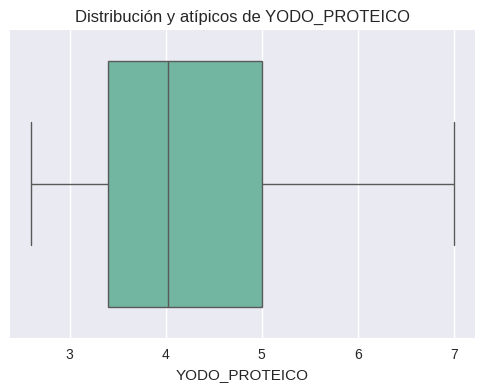

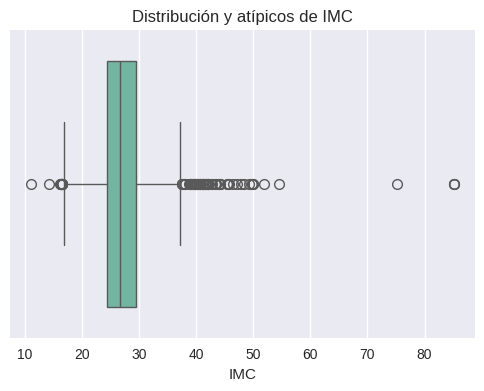

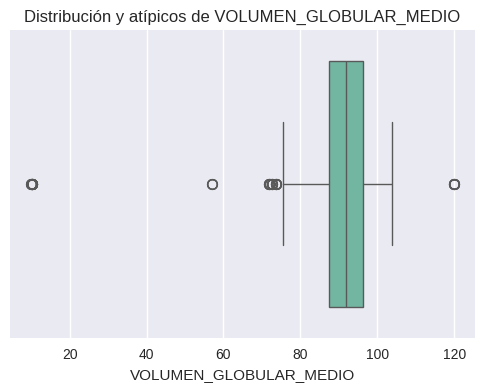

In [54]:
# Boxplot ejemplo para biomarcadores críticos
biomarkers_to_check = ["YODO_PROTEICO", "IMC", "VOLUMEN_GLOBULAR_MEDIO"]
for col in biomarkers_to_check:
    if col in master_pm_30d.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=master_pm_30d[col])
        plt.title(f"Distribución y atípicos de {col}")
        plt.show()

**5.5 Distribuciones y sesgo**

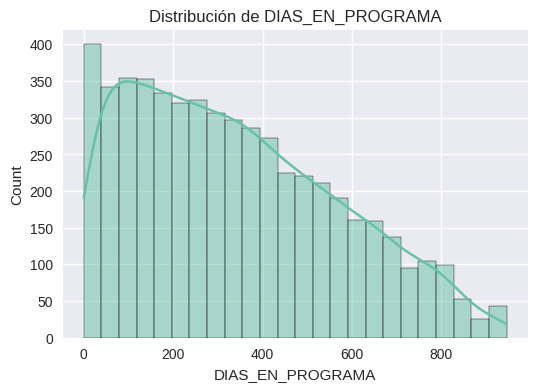

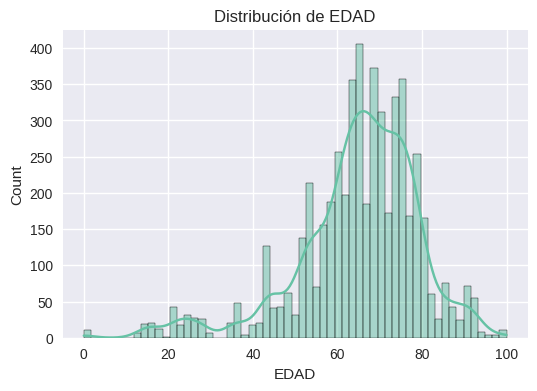

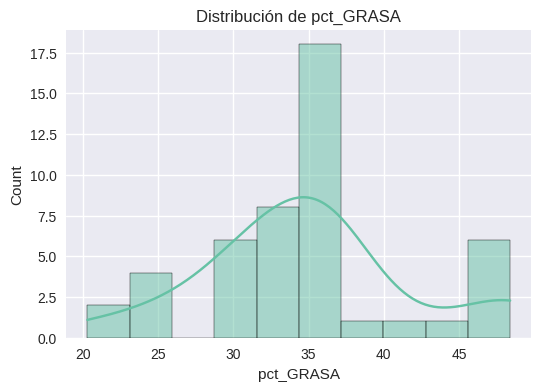

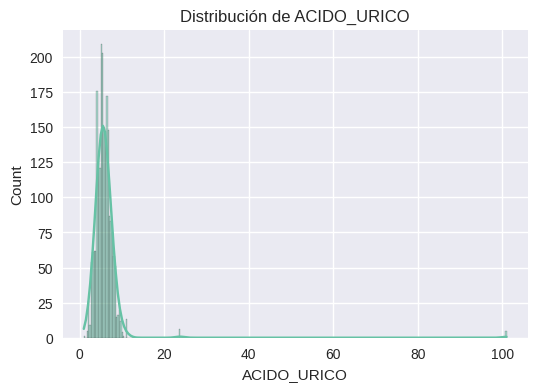

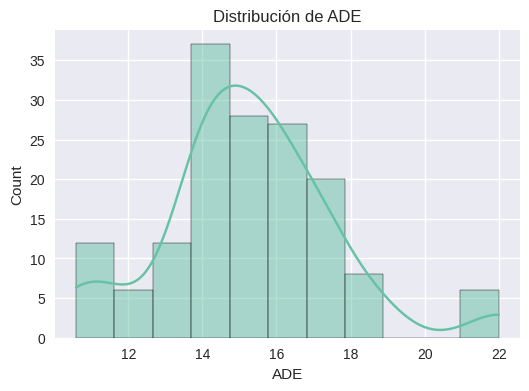

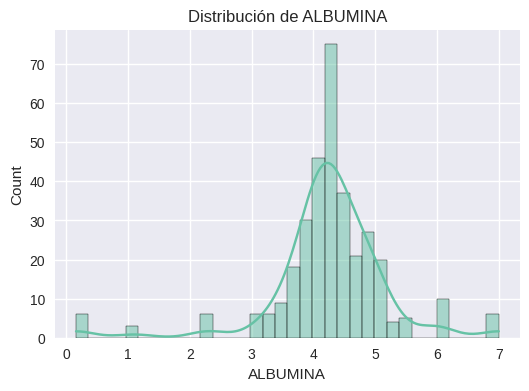

In [55]:
num_cols = master_pm_30d.select_dtypes(include=np.number).columns

for col in num_cols[:6]:  # primeras 6
    plt.figure(figsize=(6,4))
    sns.histplot(master_pm_30d[col], kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

**5.6 Correlación entre variables numéricas**

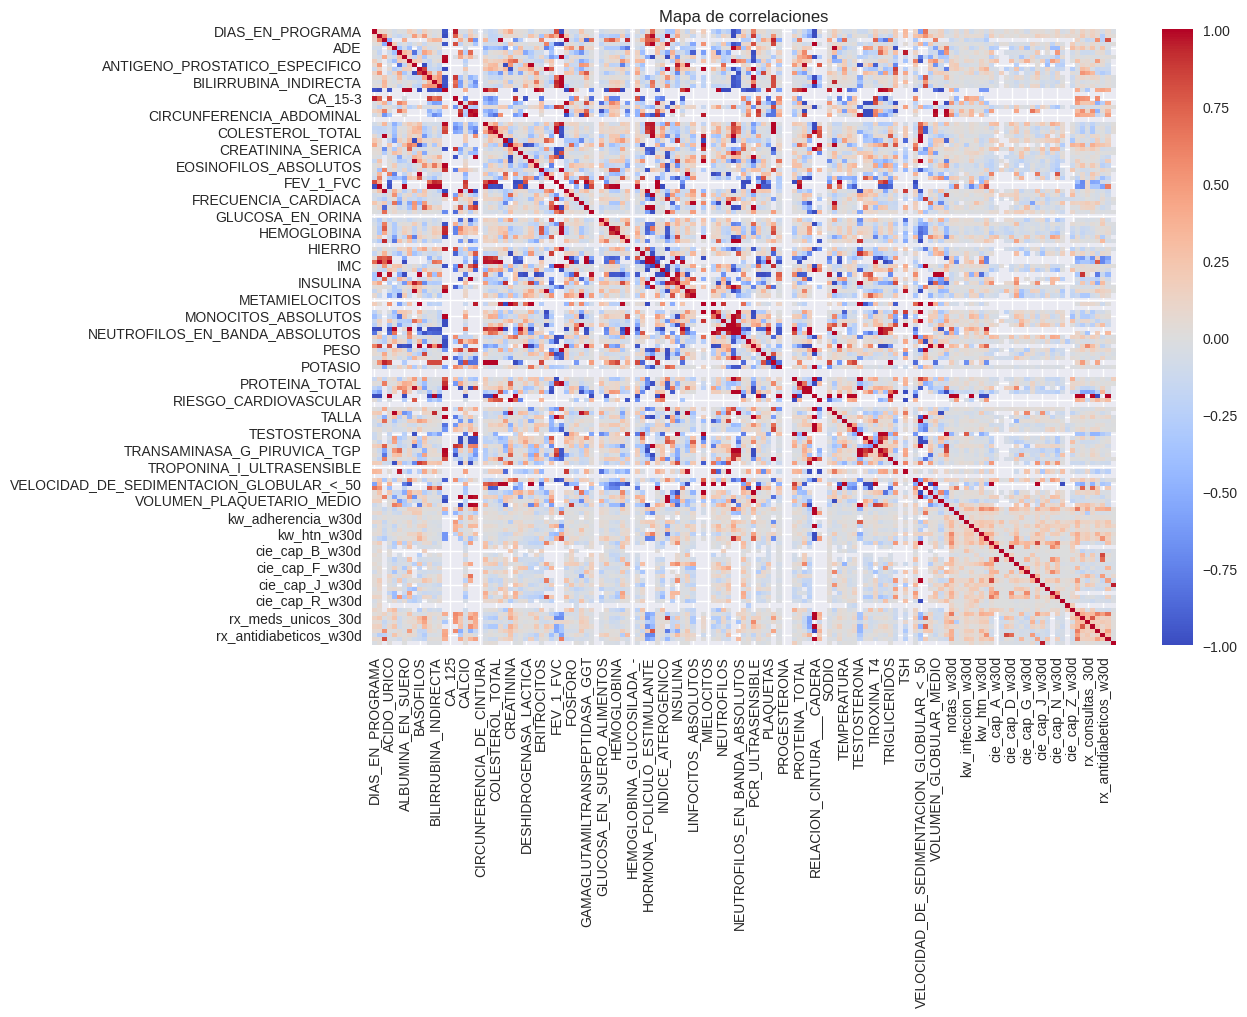

In [56]:
corr = master_pm_30d[num_cols].corr(method="pearson")
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Mapa de correlaciones")
plt.show()

In [57]:
# --- Guardar dataframe ---
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 3/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

corr.to_excel(base_path / "Matriz_Correlacion_Pearson.xlsx", index=True)

In [115]:
# ===========================
# 1) Configuración e imports
# ===========================
OUTPUT_DIR = f"{base_path}/plots_out_of_range"
SHOW_PLOTS = True            # Mostrar gráficos inline
SAVE_PLOTS = True            # Guardar PNGs en disco
MAX_PLOTS = None             # Limitar cantidad de gráficos mostrados (None = sin límite)

# Filtros opcionales (deja set() para no filtrar)
FILTER_PATIENTS = set()       # p.ej.: {"svalencia2144909"}
FILTER_BIOMARKER_IDS = set()  # p.ej.: {1, 10, 25}

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
# ==========================================
#
# ==========================================
# Este bloque:
# - Carga población, biomarcadores y rangos de referencia
# - Normaliza tipos, FECHAs y llaves de cruce
# - Estándariza el nombre de la columna "Periodicidad mínima de medición" → PERIODICIDAD

# 6.0.1) Cargar Población
df_poblacion = load_txt(f"{base_path}/01-Poblacion_v02.txt")

# 6.0.2) Cargar Biomarcadores
df_biomarcadores = load_txt(f"{base_path}/02-Biomarcadores.txt")

# 6.0.3) Cargar Rangos (Excel)
df_rangos = pd.read_excel(f"{base_path}/Rangos de referencia_biomarcadores.xlsx")

# 6.0.4) Normalizar llaves y tipos
df_poblacion["ID_EHT"] = df_poblacion["ID_EHT"].astype(str)
df_biomarcadores["ID_EHT"] = df_biomarcadores["ID_EHT"].astype(str)

df_biomarcadores["ID_BIOMARCADOR"] = df_biomarcadores["ID_BIOMARCADOR"].astype("Int64")
df_biomarcadores["VALOR"] = pd.to_numeric(df_biomarcadores["VALOR"], errors="coerce")
df_biomarcadores["FECHA"] = pd.to_datetime(df_biomarcadores["FECHA"], dayfirst=True, errors="coerce")

# 6.0.5) Normalizar nombres de columnas en rangos
rename_map = {
    "PERIORICIDAD": "PERIODICIDAD",
    "Perioricidad": "PERIODICIDAD",
    "periodicidad": "PERIODICIDAD",
    "valor_minimo": "VALOR_MINIMO",
    "valor_maximo": "VALOR_MAXIMO",
    "Periodicidad mínima de medición": "PERIODICIDAD",  # nombre exacto del archivo
}
df_rangos = df_rangos.rename(columns=rename_map)

# Si PERIODICIDAD no está, intenta localizarla por similaridad
if "PERIODICIDAD" not in df_rangos.columns:
    posibles = [c for c in df_rangos.columns if "periodicidad" in c.lower()]
    if posibles:
        df_rangos = df_rangos.rename(columns={posibles[0]: "PERIODICIDAD"})

df_rangos["ID_BIOMARCADOR"] = df_rangos["ID_BIOMARCADOR"].astype("Int64")
for c in ["VALOR_MINIMO", "VALOR_MAXIMO"]:
    if c in df_rangos.columns:
        df_rangos[c] = pd.to_numeric(df_rangos[c], errors="coerce")

print("df_poblacion:", df_poblacion.shape)
print("df_biomarcadores:", df_biomarcadores.shape)
print("df_rangos:", df_rangos.shape)

df_poblacion: (295, 7)
df_biomarcadores: (50514, 5)
df_rangos: (140, 6)


In [117]:
# ===========================================
# 3) Helpers (periodicidad, resample, plotting)
# ===========================================
FREQ_MAP = {
    "diaria": "D",
    "semanal": "W",
    "quincenal": "2W",
    "mensual": "MS",       # mes a inicio
    "trimestral": "QS",    # trimestre a inicio
    "semestral": "2QS",
    "anual": "YS",
}

def get_freq(periodicidad: str) -> str:
    """Mapea la etiqueta de periodicidad a un alias de resample de pandas."""
    if isinstance(periodicidad, str) and periodicidad.strip():
        key = periodicidad.strip().lower().split()[0]  # tolera "Mensual (mínima)"
        return FREQ_MAP.get(key, None)
    return None

def resample_by_periodicity(df: pd.DataFrame, periodicidad: str) -> pd.DataFrame:
    """Resamplea por periodicidad usando la media del periodo; si no aplica, respeta fechas crudas."""
    freq = get_freq(periodicidad)
    if not freq:
        return df.sort_values("FECHA")
    return (
        df.set_index("FECHA")
          .sort_index()
          .resample(freq)["VALOR"].mean()
          .reset_index()
    )

def safe_filename(text: str) -> str:
    return "".join(ch if ch.isalnum() or ch in "._- " else "_" for ch in str(text))

def plot_series_with_ranges(df_plot, biomarker_name, id_biomarker, patient_id,
                            vmin, vmax, outdir,
                            show=True, save=True):
    """
    Dibuja la serie temporal con banda de rango permitido y marca los puntos fuera de rango.
    Solo grafica si hay out-of-range.
    """
    if df_plot.empty:
        return None

    df_plot = df_plot.copy()
    df_plot["out_of_range"] = (df_plot["VALOR"] < vmin) | (df_plot["VALOR"] > vmax)
    if not df_plot["out_of_range"].any():
        return None

    if save:
        os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(10, 4.5))
    plt.fill_between(df_plot["FECHA"], vmin, vmax, alpha=0.15, label=f"Rango [{vmin}, {vmax}]")
    plt.plot(df_plot["FECHA"], df_plot["VALOR"], marker="o", linewidth=1, label="Serie")

    oor = df_plot[df_plot["out_of_range"]]
    plt.scatter(oor["FECHA"], oor["VALOR"], marker="o", s=60, label="Fuera de rango")

    title = f"{biomarker_name} (ID {id_biomarker}) • Paciente {patient_id}"
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()

    saved_path = None
    if save:
        fname = f"{id_biomarker}_{safe_filename(biomarker_name)}_pac_{safe_filename(patient_id)}.png"
        saved_path = os.path.join(outdir, fname)
        plt.savefig(saved_path, dpi=150)

    if show:
        plt.show()
    else:
        plt.close()

    return saved_path

In [118]:
# ==========================================
# 4) Merge biomarcadores–rangos y filtros
# ==========================================
cols_rng = ["ID_BIOMARCADOR", "PERIODICIDAD", "VALOR_MINIMO", "VALOR_MAXIMO"]
missing_cols = [c for c in cols_rng if c not in df_rangos.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas en df_rangos: {missing_cols}")

bio_rng = df_biomarcadores.merge(df_rangos[cols_rng], on="ID_BIOMARCADOR", how="left")

# Filtrar filas válidas (con fecha/valor y con límites presentes)
bio_rng = bio_rng.dropna(subset=["FECHA", "VALOR"]).copy()
bio_rng = bio_rng.dropna(subset=["VALOR_MINIMO", "VALOR_MAXIMO"], how="any")

# Filtros opcionales
if FILTER_PATIENTS:
    bio_rng = bio_rng[bio_rng["ID_EHT"].isin(FILTER_PATIENTS)]
if FILTER_BIOMARKER_IDS:
    bio_rng = bio_rng[bio_rng["ID_BIOMARCADOR"].isin(FILTER_BIOMARKER_IDS)]

print("bio_rng (post-merge+filtros):", bio_rng.shape)

bio_rng (post-merge+filtros): (50512, 8)


In [119]:
# ==========================================
# 5) Loop: resample, out-of-range, gráficas y log
# ==========================================
events = []       # lista de dicts con eventos fuera de rango (post-resample)
num_shown = 0

group_cols = ["ID_EHT", "ID_BIOMARCADOR", "NOMBRE_BIOMARCADOR",
              "PERIODICIDAD", "VALOR_MINIMO", "VALOR_MAXIMO"]

for (pid, bid, bname, per, vmin, vmax), g in bio_rng.groupby(group_cols):
    g = g[["FECHA", "VALOR"]].dropna()
    if g.empty:
        continue

    # Resample según periodicidad (media del periodo)
    g_rs = resample_by_periodicity(g, per).rename(columns={"VALOR": "VALOR"}).dropna(subset=["VALOR"])
    if g_rs.empty:
        continue

    # Detección de out-of-range
    vmin_f, vmax_f = float(vmin), float(vmax)
    g_rs["out_of_range"] = (g_rs["VALOR"] < vmin_f) | (g_rs["VALOR"] > vmax_f)
    g_oor = g_rs[g_rs["out_of_range"]]
    if g_oor.empty:
        continue

    # Registrar eventos
    for _, row in g_oor.iterrows():
        val = float(row["VALOR"])
        events.append({
            "ID_EHT": str(pid),
            "ID_BIOMARCADOR": int(bid) if pd.notna(bid) else None,
            "NOMBRE_BIOMARCADOR": bname,
            "PERIODICIDAD": per,
            "FECHA": pd.to_datetime(row["FECHA"]),
            "VALOR": val,
            "VALOR_MINIMO": vmin_f,
            "VALOR_MAXIMO": vmax_f,
            "DESVIO_ABS_MIN": (vmin_f - val) if val < vmin_f else 0.0,
            "DESVIO_ABS_MAX": (val - vmax_f) if val > vmax_f else 0.0,
        })

    # Graficar
    if (MAX_PLOTS is None) or (num_shown < MAX_PLOTS):
        plot_series_with_ranges(
            g_rs, bname, bid, pid, vmin_f, vmax_f, OUTPUT_DIR,
            show=SHOW_PLOTS, save=SAVE_PLOTS
        )
        num_shown += 1

print(f"Eventos registrados: {len(events)}")

Eventos registrados: 0


In [121]:
# ====================================================
# 6) df_events + cruce con población + CSV + pivotes
# ====================================================
EVENT_COLS = [
    "ID_EHT", "ID_BIOMARCADOR", "NOMBRE_BIOMARCADOR", "PERIODICIDAD",
    "FECHA", "VALOR", "VALOR_MINIMO", "VALOR_MAXIMO",
    "DESVIO_ABS_MIN", "DESVIO_ABS_MAX"
]

df_events = pd.DataFrame(events, columns=EVENT_COLS)

if not df_events.empty:
    # Normalizar llave
    df_events["ID_EHT"] = df_events["ID_EHT"].astype(str)

    # Columnas de población a anexar (agrega las que existan)
    pop_cols = ["ID_EHT"]
    for cand in ["SEXO", "EDAD", "EDAD_ANIOS", "MUNICIPIO", "LOCALIDAD", "ESTADO", "FECHA_NAC"]:
        if cand in df_poblacion.columns:
            pop_cols.append(cand)

    # Cruzar
    df_events = df_events.merge(
        df_poblacion[pop_cols].drop_duplicates("ID_EHT"),
        on="ID_EHT",
        how="left"
    )

    # Orden estable (si existen columnas)
    sort_by = [c for c in ["ID_EHT", "NOMBRE_BIOMARCADOR", "FECHA"] if c in df_events.columns]
    if sort_by:
        df_events = df_events.sort_values(sort_by)

    print(f"Total de puntos fuera de rango (post-resample): {len(df_events)}")

    # Guardar CSV
    events_csv_path = f"{base_path}/biomarcadores_fuera_de_rango.csv"
    df_events.to_csv(events_csv_path, index=False, encoding="utf-8")
    print(f"CSV de eventos guardado en: {events_csv_path}")

    # Pivot 1: Conteo por paciente y biomarcador (y opcionalmente por sexo)
    pivot_cols = ["ID_EHT", "NOMBRE_BIOMARCADOR"]
    if "SEXO" in df_events.columns:
        pivot_cols.append("SEXO")

    pivot = (df_events
             .groupby(pivot_cols)
             .size()
             .reset_index(name="EVENTOS_FUERA_RANGO")
             .sort_values(["ID_EHT", "EVENTOS_FUERA_RANGO"], ascending=[True, False]))
    display(pivot.head(20))

    # Pivot 2: Top global por biomarcador (y opcionalmente por sexo)
    group_top = ["NOMBRE_BIOMARCADOR"]
    if "SEXO" in df_events.columns:
        group_top.append("SEXO")

    top_bio = (df_events
               .groupby(group_top)
               .size()
               .reset_index(name="EVENTOS_FUERA_RANGO")
               .sort_values("EVENTOS_FUERA_RANGO", ascending=False)
               .head(20))
    display(top_bio)
else:
    print("No se encontraron eventos fuera de rango con los criterios actuales.")

No se encontraron eventos fuera de rango con los criterios actuales.


In [122]:
# ====================================================
# 7) (Opcional) Cohortes por edad
# ====================================================
if not df_events.empty:
    edad_col = None
    for cand in ["EDAD", "EDAD_ANIOS"]:
        if cand in df_events.columns:
            edad_col = cand
            break

    if edad_col:
        bins = [-np.inf, 17, 39, 64, 79, np.inf]
        labels = ["<=17", "18-39", "40-64", "65-79", "80+"]
        df_events["EDAD_BIN"] = pd.cut(df_events[edad_col], bins=bins, labels=labels)

        top_bio_age = (df_events
                       .groupby(["NOMBRE_BIOMARCADOR", "EDAD_BIN"])
                       .size()
                       .reset_index(name="EVENTOS_FUERA_RANGO")
                       .sort_values("EVENTOS_FUERA_RANGO", ascending=False)
                       .head(30))
        display(top_bio_age)

## **6. Conclusiones**

**6.1 Conclusión Valores Faltantes**

- **Magnitud y patrón de ausencia.** El conjunto presenta 150 variables, de las cuales 54 (36.0%) exhiben ausencia >95%. La mayoría de estas corresponden a biomarcadores de baja frecuencia de solicitud clínica (p. ej., hormonas, marcadores oncológicos, fracciones hematológicas) y a agregados de diagnósticos por capítulo (p. ej., `cie_cap_*_w30d`) con cobertura escasa. Este patrón sugiere ausencia no aleatoria (MNAR) por decisión clínica y/o sparsidad estructural derivada del modelo de atención y del recorte temporal de 30 días.

- **Decisión para el modelado.** Para mantener parsimonia y evitar sobreajuste, se excluirán del entrenamiento las 54 variables con >95% de nulos. La exclusión reduce dimensionalidad con mínima pérdida informativa esperada, dado su uso clínico esporádico y la alta sparsidad.

- **Oportunidades de mejora (imputación y codificación).**
  1) **Indicadores de ausencia (missingness dummies)** para variables continuas con 40%–95% de nulos (ej., creatinina, TSH). Esto permite capturar el valor predictivo de “no medido” sin forzar su equivalencia con valores normales.  
  2) **Imputación informada por distribución**:  
     - Continuas asimétricas (ej., glucosa, triglicéridos): mediana o quantile imputer (p50/p25–p75).  
     - Continuas aprox. simétricas: media o KNN imputer con vecinos del mismo paciente y cohorte etaria/sexo.  
     - Variables derivadas de conteos (p. ej., `rx_*_w30d`, `notas_w30d`): tratar 0 como ausencia estructural cuando el proceso indica “evento no ocurrido”; de lo contrario, conservar NaN y usar imputación a 0 solo si se confirma que el “no registro = no evento”.  
  4) **Variables categóricas** (pocas en este set): codificar por la moda.

- **Control de sesgos y fuga de información.** La imputación se realizará solo con información ≤ FECHA_MES_5, respetando la ventana retrospectiva de 30 días para evitar leakage. Se reportará la tasa de imputación por variable y se validará su impacto en la distribución mediante diagnósticos post-imputación (comparación de histogramas y medias/medianas antes/después).

- **Trabajo futuro.** Evaluar modelos robustos a nulos y comparar contra pipelines con imputación explícita. Además, considerar agrupación clínica (p. ej., panel tiroideo, perfil hepático) para reducir sparsidad y mejorar interpretabilidad.

**6.2 Conclusión de Estadisticas Descriptivas (Numéricas y Categóricas)**

- **Variables numéricas. (Mediciones y Resultados de Laboratorio)**
  1) **Perfil de los pacientes estudiados.** Adultos mayores (media 65 años), con seguimiento longitudinal amplio (media 338 días), pero con alta variabilidad (0–946 días). La edad mínima de 0 años sugiere la necesidad de depuración o segmentación.

  2) **Biomarcadores como señales de riesgo de hospitalización.** Niveles elevados de glucosa (111.6 mg/dL en ayuno), HbA1c (6.8%), y creatinina (1.21 mg/dL) son indicadores de riesgo metabólico y renal. La presencia de outliers (ej. ácido úrico = 101) requiere winsorización o imputación robusta.

  3) **Patrones de medicación como indicador.** Métricas farmacológicas (1.4 consultas/mes, 17% antihipertensivos, 18% antidiabéticos) actúan como indicadores indirectos de severidad crónica. La baja prevalencia de antibióticos (0.05%) confirma un estado ambulatorio baseline, útil para predecir transición a hospitalización.


- **Variables categóricas.**
  1) **Sesgo demográfico que afecta generalización del modelo.** El desequilibrio de género (65% hombres, 35% mujeres) y la concentración geográfica en Monterrey pueden limitar la generalización, requiriendo validación cruzada estratificada y posible re-balanceo de clases.
  2) **Polifarmacia (es cuando una persona toma muchas medicinas al mismo tiempo) como feature predictiva principal.** El 52% de pacientes con polifarmacia representa un predictor establecido de hospitalización en literatura médica. Esta variable binaria será altamente informativa para el algoritmo, especialmente en combinación con edad y comorbilidades inferidas de patrones de medicación.
  3) **Limitaciones en features categóricas estructuradas.**  La alta esparsidad en variables derivadas de texto médico (ej. cie_cap_*, kw_*) sugiere la necesidad de técnicas de reducción de dimensionalidad (PCA, selección de features) o embeddings de NLP.

**6.3 Conclusión de Valores Atípicos y Sesgos**

- **Patrones de distribución asimétrica en biomarcadores clave.** Los boxplots revelan distribuciones marcadamente asimétricas en variables críticas para predicción de hospitalización, particularmente evidente en YODO_PROTEICO. Esta asimetría sugiere presencia de subpoblaciones clínicas distintas o errores de medición que pueden impactar negativamente la performance predictiva del modelo si no se manejan adecuadamente.

- **IMC con distribución relativamente normal pero outliers significativos.**  La variable IMC muestra distribución más simétrica comparada con otros biomarcadores, pero presenta valores atípicos en ambos extremos (bajo peso severo y obesidad mórbida) que representan condiciones clínicas de alto riesgo. Estos outliers son clínicamente relevantes para predicción de hospitalización y deben preservarse como features predictivas legítimas.

- **Transformaciones logarítmicas para variables asimétricas.** Puede resultar conveniente aplicar transformaciones logarítmicas a variables con distribuciones marcadamente asimétricas (como glucosa, triglicéridos o marcadores hepáticos), con el fin de normalizar su distribución y reducir el impacto de valores extremos sin perder información predictiva. Esta transformación preserva el orden relativo de los datos y, al mismo tiempo, mitiga el efecto de los outliers en algoritmos sensibles a la escala.

- **Hallazgos en histogramas.** DIAS_EN_PROGRAMA muestra sesgo, indicando que la mayoría lleva poco tiempo en el programa. ÁCIDO_ÚRICO es cercano a normal con algunos outliers, mientras que EDAD, pct_GRASA, ADE y ALBÚMINA presentan distribuciones simétricas que no requieren transformación.


**6.4 Conclusión de Análisis de Correlación**



  - **Agrupamientos moderados de biomarcadores.** Se identifican correlaciones moderadas a altas (0.5–0.9) entre variables como peso, talla, IMC, % grasa y % muscular, así como entre presión arterial, FEVI y parámetros respiratorios (FEV1/FVC). Estos grupos reflejan dimensiones corporales, cardiovasculares y respiratorias, y podrían sintetizarse en componentes o índices compuestos para reducir redundancia y mejorar la interpretabilidad del modelo.

  - **Variables con baja correlación como fuentes de información única.** Biomarcadores como ácido úrico, albúmina, amilasa y otros presentan correlaciones bajas (<0.3) con la mayoría de las variables, lo que sugiere que aportan información no redundante y pueden ser valiosos para la predicción, siempre que se manejen adecuadamente sus valores faltantes.

  - **Estrategias de modelado recomendadas.** Dada la estructura de correlaciones observada, se sugiere el uso de técnicas de regularización (Lasso, Elastic Net) o métodos basados en árboles (Random Forest, XGBoost) que son robustos a la multicolinealidad. También se recomienda la creación de variables compuestas o la aplicación de PCA en grupos altamente correlacionados para mejorar la eficiencia y generalización del modelo.


## 6.5 Conclusión General del Análisis Exploratorio

El dataset presenta un **perfil clínico complejo**, caracterizado por:

- **Esparsidad heterogénea**, con variables de alta proporción de nulos.  
- **Outliers clínicamente significativos**, que aportan información valiosa en casos extremos.  
- **Correlaciones estructuradas por sistemas fisiológicos**, agrupando dimensiones corporales, cardiovasculares y respiratorias.  

### Implicaciones para el pipeline de modelado

1. **Excluir variables con >95% de nulos**, reduciendo dimensionalidad y evitando ruido.  
2. **Implementar imputación robusta** (medianas, quantiles, KNN por cohorte) y aplicar **transformaciones logarítmicas** a biomarcadores asimétricos.  
3. **Incorporar polifarmacia y biomarcadores clave** (glucosa, HbA1c, creatinina, IMC) como *features* prioritarios para el modelo.  
4. **Aplicar técnicas de reducción de dimensionalidad** (PCA, índices compuestos) en grupos altamente correlacionados, para mejorar parsimonia e interpretabilidad.  
5. **Validar los modelos con enfoque estratificado**, considerando **sesgos demográficos** (género, edad) y **geográficos** (concentración en Monterrey).  

# ---

### 6.6 Hallazgo operativo: validación de rangos y reenvío de insumos

Durante la verificación “paciente vs. biomarcador en el tiempo” **no se detectaron eventos fuera de rango** con los límites disponibles en `Rangos de referencia_biomarcadores.xlsx`. Esto sugiere que:

- Los umbrales actuales **funcionan como límites de plausibilidad** más que como **rangos clínicos de referencia**, por lo que no activan alertas útiles.
- Podría haber **desalineación de unidades** o faltan **estratos de cohorte** (sexo/edad/condición) que cambian los cortes “normales”.
- El **resample por periodicidad** (p.ej. promedio mensual) puede estar **suavizando picos** clínicamente relevantes.

**Acción recomendada (validación con el usuario):**
1. Solicitar una versión del catálogo con columnas explícitas:  
   `UNIDAD`, `RANGO_CLIN_MIN`, `RANGO_CLIN_MAX`, `PLAUS_MIN`, `PLAUS_MAX`, `SEXO`, `EDAD_MIN`, `EDAD_MAX`, `Periodicidad mínima de medición`.  
2. Confirmar que las **unidades** en datos crudos coincidan con `UNIDAD` (p.ej., mg/dL vs mmol/L) o proveer tabla de conversión.  
3. Indicar si la detección debe hacerse sobre **punto crudo** (máximo del periodo para capturar picos) o **agregado** (promedio/mediana por la periodicidad).  
4. Si aplica, proporcionar **rangos por cohorte** (sexo y grupos de edad) para glucosa, creatinina, TA, lípidos, etc.

> En cuanto llegue la versión actualizada del catálogo, se re-ejecutará el pipeline para generar el **CSV de eventos fuera de rango clínico** y las **gráficas con doble banda** (plausibilidad + referencia clínica).
